# Bayesian Golf Putting Model
> Are you the next Tiger Woods?.

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/chart-preview.png

# Introduction

## Disclaimer

This is inspired from Dr. Andrew Gelman's case study, which can be found [here](https://mc-stan.org/users/documentation/case-studies/golf.html). Specifically:

- This is heavily inspired by Colin Caroll's Blog present [here](https://nbviewer.jupyter.org/github/pymc-devs/pymc3/blob/master/docs/source/notebooks/putting_workflow.ipynb). A lot of the plotting code from his blog post has been reused.
- Josh Duncan's blog post on the same topic which can be found [here](https://jduncstats.com/post/2019-11-02_golf-turing/).

This is not a novel solution. It is merely a replication of Dr. Gelman's blog in PyMC3.

## Problem

This is based on a popular blog post by Dr. Andrew Gelman. Here, we are given data from professional golfers on the proportion of success putts from a number of tries. Our aim is to identify:

> Can we model the probability of success in golf putting as a function of distance from the hole?

## EDA

In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


The source repository is present [here](https://github.com/stan-dev/example-models/tree/master/knitr/golf)

In [2]:
data = np.array([[2,1443,1346],
[3,694,577],
[4,455,337],
[5,353,208],
[6,272,149],
[7,256,136],
[8,240,111],
[9,217,69],
[10,200,67],
[11,237,75],
[12,202,52],
[13,192,46],
[14,174,54],
[15,167,28],
[16,201,27],
[17,195,31],
[18,191,33],
[19,147,20],
[20,152,24]])

df = pd.DataFrame(data, columns=[
    'distance', 
    'tries', 
    'success_count'
])

In [3]:
df

,distance,tries,success_count
0,2,1443,1346
1,3,694,577
2,4,455,337
3,5,353,208
4,6,272,149
5,7,256,136
6,8,240,111
7,9,217,69
8,10,200,67
9,11,237,75


The variables have the following format:

| Variable      | Units | Description                                 |
|---------------|-------|---------------------------------------------|
| distance      | feet  | Distance from the hole for the putt attempt |
| tries         | count | Number of attempts at the chosen distance   |
| success_count | count | The total successful putts                  |

Lets try to visualize the dataset:

In [4]:
df['success_prob'] = df.success_count / df.tries

[Text(0, 0.5, 'Probability of Success'),
 Text(0.5, 0, 'Distance from hole(ft)')]

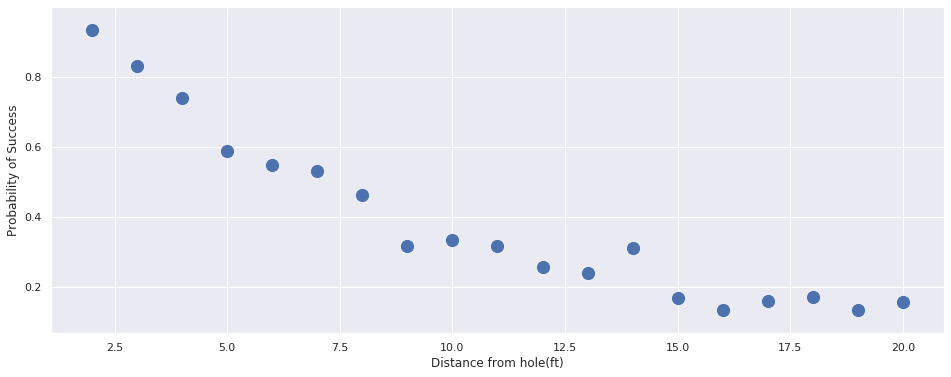

In [5]:
sns.set()
plt.figure(figsize=(16, 6))
ax = sns.scatterplot(x='distance', y='success_prob', data=df, s=200)
ax.set(xlabel='Distance from hole(ft)', ylabel='Probability of Success')

We can notice that the **probability of success decreases as the distance increases.**


# Baseline Model

Let us try to see we can fit a simple linear model to the data i.e Logsitic Regression. We will be using PyMC3.

Here, we will attempt to model the success of golf putting by using the distance as an independant(i.e predictor) variable. The model will have the following form:

**$$y_i \sim binomial(n_j, logit^{-1}(b_0 + b_1x_j)), \text{for } j = 1,...J $$**

In [6]:
with pm.Model() as model:
    b_0 = pm.Normal('b_0', mu=0, sd=1)
    b_1 = pm.Normal('b_1', mu=0, sd=1)
        
    y = pm.Binomial(
        'y', 
        n=df.tries, 
        p=pm.math.invlogit(b_0 + b_1 * df.distance), 
        observed=df.success_count
    )

Why are we using inverse logit?

- **Logit** is a function used to convert a continous variable to a value in the range [0,1]
- **Inverse Logit**: Used to convert real valued variable to a value in the range [0,1]

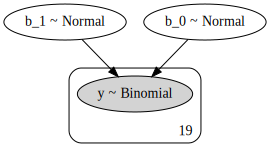

In [7]:
pm.model_to_graphviz(model)

In [14]:
with model:
    trace = pm.sample(1000, tune=1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [b_1, b_0]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:06<00:00, 1155.13draws/s]


In [15]:
pm.summary(trace)[['mean', 'sd', 'mcse_mean', 'mcse_sd', 'ess_mean', 'r_hat']]

,mean,sd,mcse_mean,mcse_sd,ess_mean,r_hat
b_0,2.226,0.058,0.002,0.001,1036.0,1.0
b_1,-0.255,0.007,0.000,0.000,1028.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4c1daf5b00>,
      dtype=object)

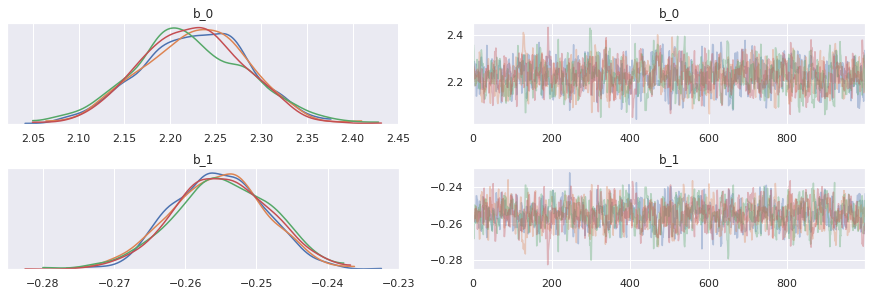

In [16]:
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4c1e1f5a58>,
      dtype=object)

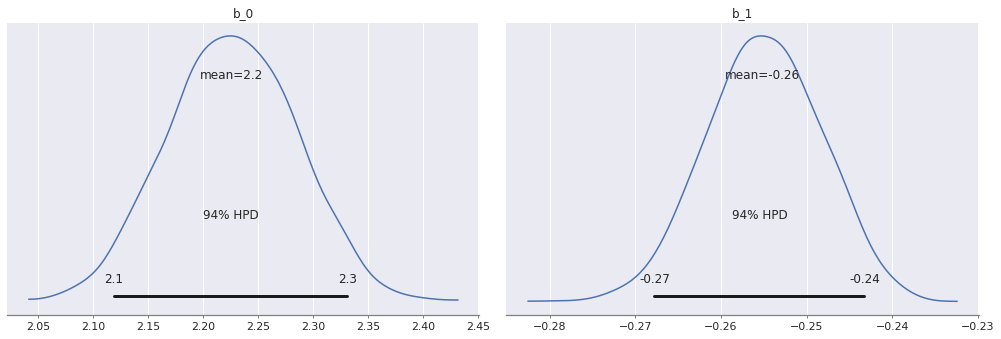

In [17]:
pm.plot_posterior(trace)

From the above results, we can see:

- PyMC3 has estimated 
  - $b_0$ to be $2.23 \pm 0.057$
  - $b_1$ to be $-0.26 \pm 0.007$
- The MCSE is almost 0 $\implies$ The simulation has run long enough for the chains to converge.
- $r\_hat = 1.0$ tells us that the chains have mixed well i.e hairy hedgehog pattern.

Let us plot the final output of this model and check it with our training data.

In [18]:
with model:
    posterior_trace = pm.sample_posterior_predictive(trace)

100%|██████████| 4000/4000 [00:03<00:00, 1074.81it/s]


In [19]:
posterior_success = posterior_trace['y'] / df.tries.values

In [20]:
df['posterior_success_prob'] = pd.DataFrame(posterior_success).median()
df['posterior_success_prob_std'] = pd.DataFrame(posterior_success).std()

[Text(0, 0.5, 'Probability of Success'),
 Text(0.5, 0, 'Distance from hole(ft)')]

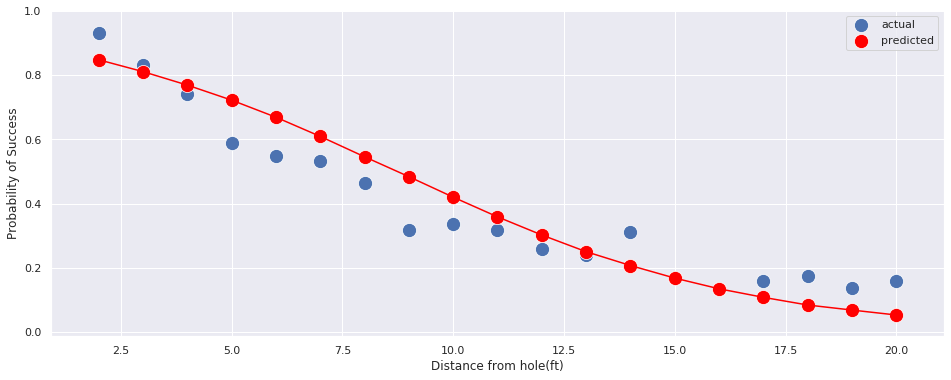

In [21]:
sns.set()
plt.figure(figsize=(16, 6))
prob = df.success_count/df.tries
ax = sns.scatterplot(x='distance', y=df.success_prob, data=df, s=200, label='actual')
# ls = np.linspace(0, df.distance.max(), 200)
# for index in np.random.randint(0, len(trace), 50):
#     ax.plot(
#         ls, 
#         scipy.special.expit(
#             trace['b_0'][index] * ls + trace['b_1'][index] * ls
#         )
#     )
sns.scatterplot(x='distance', y=df.posterior_success_prob, data=df, label='predicted',ax=ax, color='red', s=200)
sns.lineplot(x='distance', y=df.posterior_success_prob, data=df,ax=ax, color='red')
ax.set(xlabel='Distance from hole(ft)', ylabel='Probability of Success')

The curve fit is okay, but it can be improved. We can use this as a baseline model. In reality, each of them is not a point, but an posterior estimate. Because the uncertainity is small(as seen above), we've decided to show only the median points.

From the above model, putts from 50ft are expected to be made with probability:

In [22]:
import scipy
res = 100 * scipy.special.expit(2.223 + -0.255 * 50).mean()
print(np.round(res, 5),"%")

0.00268 %


# Modelling from first principles

## Geometry based Model

In [23]:
from IPython.display import Image

Image(url='./golf_ball_trajectory.png')

We'll try to accomodate the physics associated with the problem. Specically, we assume:

##### Assumptions
- The golfers can hit the ball in any direction with some small error. This error could be because of inaccuracy, errors in the human, etc.
- This error refers to the angle of the shot.
- We assume the angle is **normally** distributed.
  - 

###### Implications
- The ball goes in whenever the angle is small enough for it to hit the cup of the hole!
- Longer putt $\implies$ Larger error $\implies$ Lower success rate than shorter putt

From Dr. Gelman's blog, we obtain the formula as:

> $Pr(|angle| < sin^{-1}(\frac{(R-r)}{x})) = 2\phi\big(\frac{sin^{-1}\frac{R-r}{x}}{\sigma}\big) - 1$ 

$\phi \implies$ Cumulative Normal Distribution Function.

Hence, our model will now have two big parts:

$$y_j \sim binomial(n_j, p_j)$$

$$p_j = 2\phi\big(\frac{sin^{-1}\frac{R-r}{x}}{\sigma}\big) - 1$$

Typically, the diameter of a golf ball is 1.68 inches and the cup is 4.25 inches i.e

$$r = 1.68 \text{inch}$$
$$R = 4.25 \text{inch}$$

In [24]:
ball_radius = (1.68/2)/12
cup_radius = (4.25/2)/12


In [25]:
def calculate_prob(angle, distance):
    """
    """
    rad = angle * np.pi / 180.0
    arcsin = np.arcsin((cup_radius - ball_radius)/ distance)
    return 2 * scipy.stats.norm(0, rad).cdf(arcsin) - 1

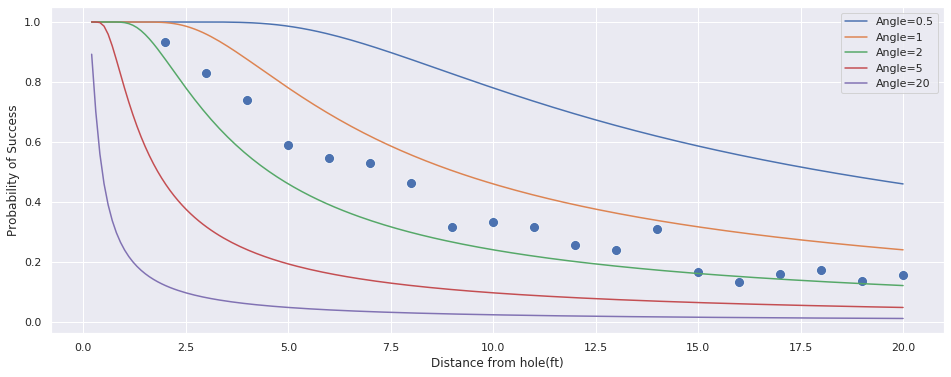

In [26]:
plt.figure(figsize=(16, 6))
ls = np.linspace(0, df.distance.max(), 200)
ax = sns.scatterplot(
    x='distance', 
    y='success_prob', 
    data=df, 
    s=100,
    legend='full'
)
for angle in [0.5, 1, 2, 5, 20]:
    ax.plot(
        ls, 
        calculate_prob(angle, ls), 
        label=f"Angle={angle}"
    )
ax.set(
    xlabel='Distance from hole(ft)', 
    ylabel='Probability of Success'
)
ax.legend()

Let us now add this to our model!

In [27]:
import theano.tensor as tt


def calculate_phi(num):
    "cdf for standard normal"
    q = tt.erf(num / tt.sqrt(2.0)) # ERF is the Gaussian Error 
    return (1.0 + q) / 2.

In [28]:
with pm.Model() as model:
    angle_of_shot_radians = pm.HalfNormal('angle_of_shot_radians')
    angle_of_shot_degrees = pm.Deterministic(
        'angle_of_shot_degrees',
        (angle_of_shot_radians * 180.0) / np.pi
    )
    p_ball_goes_in = pm.Deterministic(
        'p_ball_goes_in',
        2 * calculate_phi(
                tt.arcsin(
                    (cup_radius - ball_radius)/ df.distance
                ) / angle_of_shot_radians
            )
        ) - 1
    p_success = pm.Binomial(
        'p_success',
        n=df.tries, 
        p=p_ball_goes_in, 
        observed=df.success_count
    )

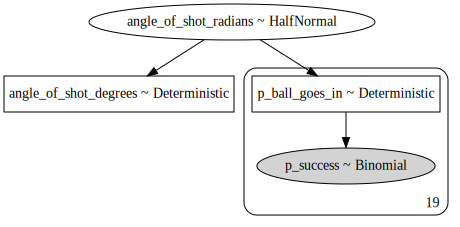

In [29]:
pm.model_to_graphviz(model)

In [30]:
with model:
    trace = pm.sample(4000, tune=1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
ERROR (theano.gof.opt): Optimization failure due to: local_grad_log_erfc_neg
ERROR (theano.gof.opt): node: Elemwise{true_div}(Elemwise{mul,no_inplace}.0, Elemwise{erfc,no_inplace}.0)
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/home/goodhamgupta/shubham/golf_tutorial/.env/lib/python3.6/site-packages/theano/gof/opt.py", line 2034, in process_node
    replacements = lopt.transform(node)
  File "/home/goodhamgupta/shubham/golf_tutorial/.env/lib/python3.6/site-packages/theano/tensor/opt.py", line 6789, in local_grad_log_erfc_neg
    if not exp.owner.inputs[0].owner:
AttributeError: 'NoneType' object has no attribute 'owner'

Multiprocess sampling (4 chains in 2 jobs)
NUTS: [angle_of_shot_radians]
Sampling 4 chains, 0 divergences: 100%|██████████| 20000/20000 [00:15<00:00, 1268.74draws/s]


In [31]:
pm.summary(trace).head(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
angle_of_shot_radians,0.027,0.000,0.026,0.027,0.0,0.0,6816.0,6815.0,6826.0,11256.0,1.0
angle_of_shot_degrees,1.527,0.023,1.484,1.570,0.0,0.0,6816.0,6815.0,6826.0,11256.0,1.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7f184de8d0>],
      dtype=object)

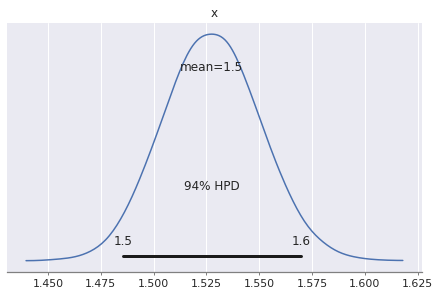

In [66]:
pm.plot_posterior(trace['angle_of_shot_degrees'])

From the above results, we can see:

- PyMC3 has estimated 
  - $angle_of_shot_degrees$ to be $1.53 \pm 0.023$
- The MCSE is almost 0 $\implies$ The simulation has run long enough for the chains to converge.
- $r\_hat = 1.0$ tells us that the chains have mixed well i.e hairy hedgehog pattern.

Let's visualize the fit with this new model:

In [67]:
geo_model_prob = calculate_prob(
    trace['angle_of_shot_degrees'].mean(), 
    df.distance
)

[Text(0, 0.5, 'Probability of Success'),
 Text(0.5, 0, 'Distance from hole(ft)')]

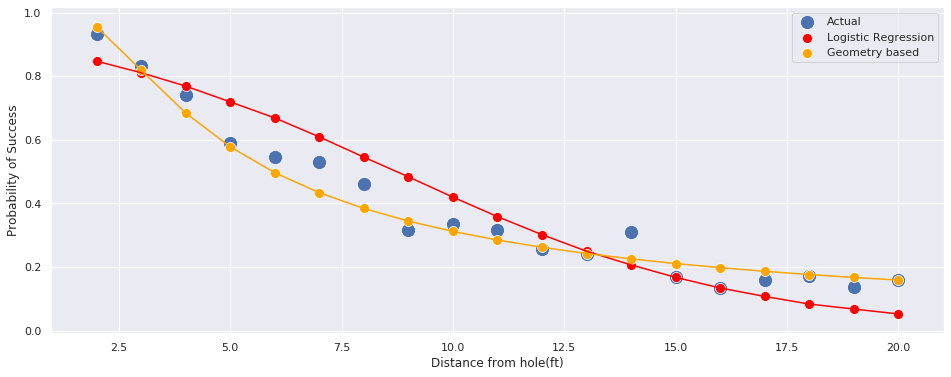

In [68]:
sns.set()
plt.figure(figsize=(16, 6))

ax = sns.scatterplot(x='distance', y=df.success_prob, data=df, s=200, label='Actual')

sns.scatterplot(x='distance', y=df.posterior_success_prob, data=df, label='Logistic Regression',ax=ax, color='red', s=100)
sns.scatterplot(x='distance', y=geo_model_prob, data=df, label='Geometry based ',ax=ax, color='orange', s=100)

sns.lineplot(x='distance', y=df.posterior_success_prob, data=df,ax=ax, color='red')
sns.lineplot(x='distance', y=geo_model_prob, data=df,ax=ax, color='orange')

ax.set(xlabel='Distance from hole(ft)', ylabel='Probability of Success')

- We can see that the geometry based model fits better than the logistic regression model. 
- While this model is not completely accurate, it suggests that angle is a good variable to model the problem. Using this model, we can be more confident about extrapolating the data. 
- For the same 50ft putt, the probability now is:

In [30]:
import scipy
lr_result = np.round(
    100 * scipy.special.expit(2.223 + -0.255 * 50).mean(),
    5
)
geo_result = np.round(
    100 * calculate_prob(
        trace['angle_of_shot_degrees'].mean(), 
        50
    ).mean(),
    5
)

print(
    f"Logistic Regression Model: {lr_result}% \n"\
    f"Geometry Based Model: {geo_result}%"
)

Logistic Regression Model: 0.00268% 
Geometry Based Model: 6.4021%


## New Data!

Mark Broadie obtained new data about the golfers. Let's see how our model performs on this new dataset. 

First, we'll look at the summary of the dataset.

In [77]:
#  golf putting data from Broadie (2018)
new_golf_data = np.array([
[0.28, 45198, 45183],
[0.97, 183020, 182899],
[1.93, 169503, 168594],
[2.92, 113094, 108953],
[3.93, 73855, 64740],
[4.94, 53659, 41106],
[5.94, 42991, 28205],
[6.95, 37050, 21334],
[7.95, 33275, 16615],
[8.95, 30836, 13503],
[9.95, 28637, 11060],
[10.95, 26239, 9032],
[11.95, 24636, 7687],
[12.95, 22876, 6432],
[14.43, 41267, 9813],
[16.43, 35712, 7196],
[18.44, 31573, 5290],
[20.44, 28280, 4086],
[21.95, 13238, 1642],
[24.39, 46570, 4767],
[28.40, 38422, 2980],
[32.39, 31641, 1996],
[36.39, 25604, 1327],
[40.37, 20366, 834],
[44.38, 15977, 559],
[48.37, 11770, 311],
[52.36, 8708, 231],
[57.25, 8878, 204],
[63.23, 5492, 103],
[69.18, 3087, 35],
[75.19, 1742, 24],
])

new_df = pd.DataFrame(
    new_golf_data, 
    columns=['distance', 'tries', 'success_count']
)

In [84]:
new_geo_model_prob = calculate_prob(
    trace['angle_of_shot_degrees'].mean(), 
    new_df.distance
)

[None, None, None, None, None, None]

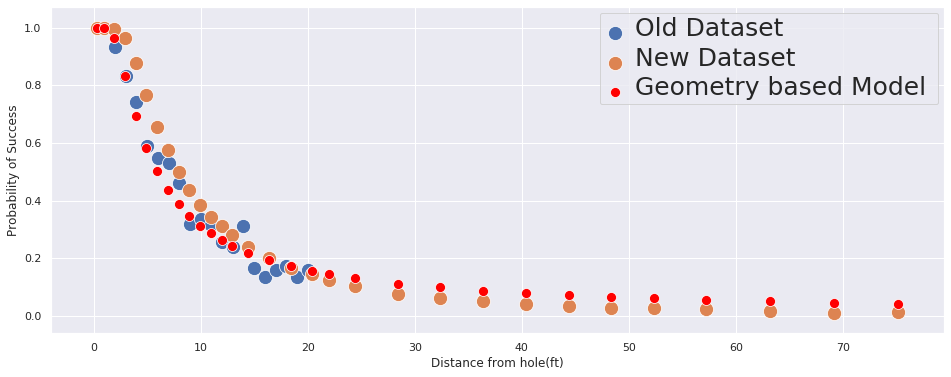

In [94]:
new_df['success_prob'] = new_df.success_count / new_df.tries
sns.set()
plt.figure(figsize=(16, 6))
ax = sns.scatterplot(x='distance', y='success_prob', data=df, label='Old Dataset', s=200)
sns.scatterplot(x='distance', y='success_prob', data=new_df,label='New Dataset', s=200, ax=ax)
sns.scatterplot(x='distance', y=new_geo_model_prob, data=new_df, label='Geometry based Model ',ax=ax, color='red', s=100)
ax.set(
    xlabel='Distance from hole(ft)', 
    ylabel='Probability of Success'
)
plt.setp(ax.get_legend().get_texts(), fontsize='25')

We can see:

- Success rate is similar in the 0-20 feet range for both datasets.
- Beyond 20 ft, success rate is lower than expected. These attempts are more difficult, even after we have accounted for increased angular precision.

## Moar features!

To get the ball in, along with the angle, we should also need to take into account if the ball was hit **hard enough**.

From Colin Caroll's Blog, we have the following:
> Mark Broadie made the following assumptions
- If a putt goes short or more than 3 feet past the hole, it will not go in.
- Golfers aim for 1 foot past the hole
- The distance the ball goes, $u$, is distributed as:
$$ u \sim \mathcal{N}\left(1 + \text{distance}, \sigma_{\text{distance}} (1 + \text{distance})\right), $$ where we will learn $\sigma_{\text{distance}}$.

After working through the geometry and algebra, we get:

$$P(\text{Good shot}) = \bigg(2\phi\big(\frac{sin^{-1}(\frac{R-r}{x})}{\sigma_{angle}}\big)-1\bigg)\bigg(\phi\bigg(\frac{2}{(x+1)\sigma_{distance}}\bigg) - \phi\bigg(\frac{-1}{(x+1)\sigma_{distance}}\bigg)\bigg)$$

Let's write this down in PyMC3

In [107]:
OVERSHOT = 1.0
DISTANCE_TOLERANCE = 3.0
distances = new_df.distance.values
with pm.Model() as model:
    angle_of_shot_radians = pm.HalfNormal('angle_of_shot_radians')
    angle_of_shot_degrees = pm.Deterministic(
        'angle_of_shot_degrees',
        (angle_of_shot_radians * 180.0) / np.pi
    )
    
    variance_of_distance = pm.HalfNormal('variance_of_distance')
    p_good_angle = pm.Deterministic(
        'p_good_angle',
        2 * calculate_phi(
                tt.arcsin(
                    (cup_radius - ball_radius)/ distances
                ) / angle_of_shot_radians
            )
        ) - 1
    p_good_distance = pm.Deterministic(
        'p_good_distance',
        calculate_phi(
            (DISTANCE_TOLERANCE - OVERSHOT) / ((distances + OVERSHOT) * variance_of_distance)) 
        - calculate_phi(
            -OVERSHOT / ((distances + OVERSHOT) * variance_of_distance))

    )
    p_success = pm.Binomial(
        'p_success',
        n=new_df.tries, 
        p=p_good_angle * p_good_distance, 
        observed=new_df.success_count
    )
    

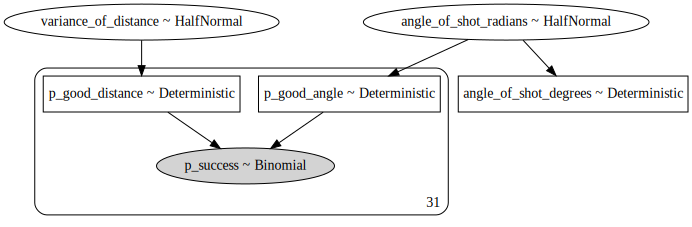

In [108]:
pm.model_to_graphviz(model)

In [109]:
with model:
    trace = pm.sample(1000, tune=1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [variance_of_distance, angle_of_shot_radians]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [01:57<00:00, 67.90draws/s]  
The acceptance probability does not match the target. It is 0.9997747107105002, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [110]:
pm.summary(trace).head(3)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
angle_of_shot_radians,0.013,0.000,0.013,0.013,0.0,0.0,810.0,810.0,818.0,1268.0,1.01
angle_of_shot_degrees,0.761,0.003,0.755,0.768,0.0,0.0,810.0,810.0,818.0,1268.0,1.01
variance_of_distance,0.137,0.001,0.136,0.138,0.0,0.0,935.0,935.0,936.0,1361.0,1.01


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7f112347f0>],
      dtype=object)

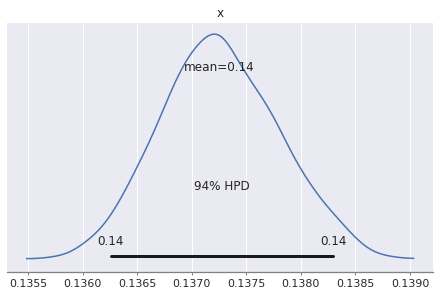

In [128]:
pm.plot_posterior(trace['variance_of_distance'])

In [113]:
with model:
    distance_posterior = pm.sample_posterior_predictive(trace)

100%|██████████| 4000/4000 [00:06<00:00, 627.04it/s]


In [150]:
def calculate_prob_distance(angle, distance, ls):
    """
    Calculate the probability the ball will land inside the hole
    given the variance in angle and distance.
    
    NOTE: Adapted from Colin Carroll's Blog.
    """
    norm = scipy.stats.norm(0, 1)
    prob_angle = 2 * norm.cdf(
        np.arcsin((cup_radius - ball_radius) / ls) / angle) - 1
    prob_distance_one = norm.cdf(
        (DISTANCE_TOLERANCE - OVERSHOT) / ((ls + OVERSHOT) * distance)
    )
    prob_distance_two = norm.cdf(-OVERSHOT / ((ls + OVERSHOT) * distance))
    prob_distance = prob_distance_one - prob_distance_two
    
    return prob_angle * prob_distance

In [137]:
distance_model_prob = []
for point in ls:
    prob = 
    distance_model_prob.append(prob)
    

In [142]:
ls = np.linspace(0, new_df.distance.max(), 200)

[None, None, None, None, None, None]

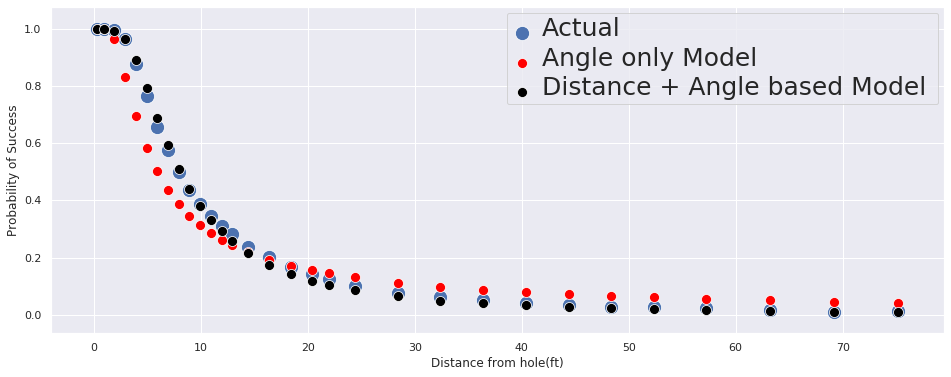

In [156]:
new_df['success_prob'] = new_df.success_count / new_df.tries
sns.set()
plt.figure(figsize=(16, 6))
ax = sns.scatterplot(
    x='distance', 
    y='success_prob',
    data=new_df,
    label='Actual', 
    s=200
)
sns.scatterplot(
    x='distance', 
    y=new_geo_model_prob, 
    data=new_df, 
    label='Angle only Model',
    ax=ax, 
    color='red', 
    s=100
)

sns.scatterplot(
    x='distance', 
    y=calculate_prob_distance(
        trace['angle_of_shot_radians'].mean(), 
        trace['variance_of_distance'].mean(),
        new_df.distance
    ), 
    data=new_df, 
    label='Distance + Angle based Model ',
    ax=ax, 
    color='black', 
    s=100
)
ax.set(
    xlabel='Distance from hole(ft)', 
    ylabel='Probability of Success'
)

plt.setp(ax.get_legend().get_texts(), fontsize='25')

From the graph, we can conclude that:

- The model is good at distance lower than 10 ft and distances higher than 40ft.
- There is some mismatch between 10ft to 40ft, but overall this is a good fit.

## What's the point?

Using Bayesian analysis, we want to be able to quantify the unvertainity with each of our predictions. Since each prediction is a distribution, we can utilize this to see where the putts will fall if they do not fall in the hole.

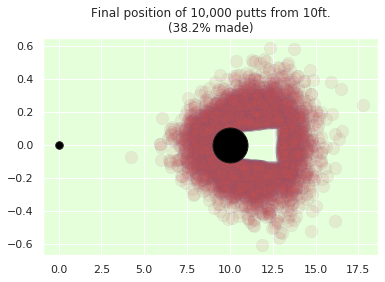

In [166]:
def simulate_from_distance(trace, distance_to_hole, trials=10_000):
    n_samples = trace['angle_of_shot_radians'].shape[0]

    idxs = np.random.randint(0, n_samples, trials)
    variance_of_shot = trace['angle_of_shot_radians'][idxs]
    variance_of_distance = trace['variance_of_distance'][idxs]

    theta = np.random.normal(0, variance_of_shot)
    distance = np.random.normal(distance_to_hole + OVERSHOT, (distance_to_hole + OVERSHOT) * variance_of_distance)

    final_position = np.array([distance * np.cos(theta), distance * np.sin(theta)])

    made_it = np.abs(theta) < np.arcsin((cup_radius - ball_radius) / distance_to_hole)
    made_it = made_it * (final_position[0] > distance_to_hole) * (final_position[0] < distance_to_hole + DISTANCE_TOLERANCE)
    
    _, ax = plt.subplots()

    ax.plot(0, 0, 'k.', lw=1, mfc='black', ms=150 / distance_to_hole)
    ax.plot(*final_position[:, ~made_it], '.', alpha=0.1, mfc='r', ms=250 / distance_to_hole, mew=0.5)
    ax.plot(distance_to_hole, 0, 'ko', lw=1, mfc='black', ms=350 / distance_to_hole)

    ax.set_facecolor("#e6ffdb")
    ax.set_title(f"Final position of {trials:,d} putts from {distance_to_hole}ft.\n({100 * made_it.mean():.1f}% made)")
    return ax

simulate_from_distance(trace, distance_to_hole=10);

# Conclusion

We've just seen how incorporate subjective knowledge in our models and help them fit cases that are specific to our use-case.

References:

- This is heavily inspired by Colin Caroll's Blog present [here](https://nbviewer.jupyter.org/github/pymc-devs/pymc3/blob/master/docs/source/notebooks/putting_workflow.ipynb)
- The crux of this post is based on Dr. Gelman's case study present [here](https://mc-stan.org/users/documentation/case-studies/golf.html).